In [ ]:
Step-by-Step Algorithm:

1. Load Dataset:
Read the dataset from a local CSV file using pandas.

2. Extract Features and Labels:
Separate the features (input data) and the target labels (true labels).

3. Initialize KMeans:
Create a KMeans object with the desired number of clusters and a random state for reproducibility.

4. Fit the Model:
Fit the KMeans model to the feature data.

5. Predict Clusters:
Predict the cluster for each data point using the trained KMeans model.

6. Map Cluster Labels to True Labels:
For each predicted cluster, map it to the most common true label (using the mode) to understand how the predicted clusters correspond to the actual classes.

7. Calculate Metrics:
Compute the accuracy, F1 score, precision, recall, silhouette score, and adjusted Rand index to evaluate the clustering performance.

8. Visualize Clusters:
Create a scatter plot of the first two features, color-coded by cluster labels, and plot the cluster centers.

9. Compute Confusion Matrix:
Generate a confusion matrix comparing true labels to the mapped cluster labels.


    or

Initialize Spark Session
Load the dataset from the provided file path
Rename columns to match the dataset structure
Assemble features for K-Means clustering
Initialize KMeans with 3 clusters
Make predictions and evaluate the silhouette score
display cluster centers
Convert Spark DataFrame to Pandas for plotting
Plotting
Stop the Spark Session

# KMeans.csv

+----------+--------+--------------------+
|        id|distance|overspeed_percentage|
+----------+--------+--------------------+
|3423311935|   71.24|                  28|
|3423313212|   52.53|                  25|
|3423313724|   64.54|                  27|
|3423311373|   55.69|                  22|
|3423310999|   54.58|                  25|
|3423313857|   41.91|                  10|
|3423312432|   58.64|                  20|
|3423311434|   52.02|                   8|
|3423311328|   31.25|                  34|
|3423312488|   44.31|                  19|
+----------+--------+--------------------+
only showing top 10 rows

root
 |-- id: long (nullable = true)
 |-- distance: double (nullable = true)
 |-- overspeed_percentage: integer (nullable = true)

+------------+
|    features|
+------------+
|[71.24,28.0]|
|[52.53,25.0]|
|[64.54,27.0]|
|[55.69,22.0]|
|[54.58,25.0]|
|[41.91,10.0]|
|[58.64,20.0]|
| [52.02,8.0]|
|[31.25,34.0]|
|[44.31,19.0]|
+------------+
only showing top 10 rows

+----

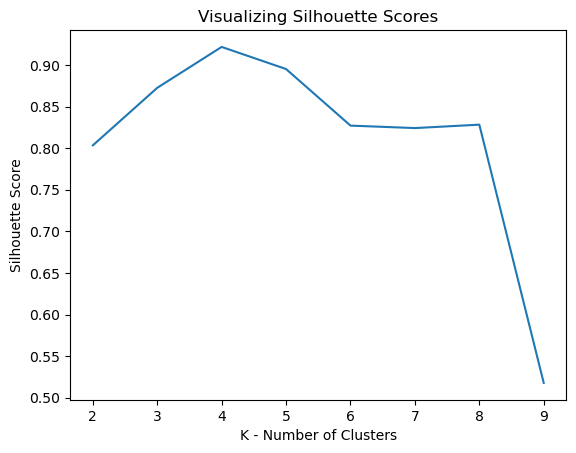

Cluster Centers: 
[1.56788767 3.29873459]
[0.93513116 0.43667816]
[3.37469648 0.7654202 ]
+----------+
|prediction|
+----------+
|         0|
|         1|
|         0|
|         1|
|         1|
|         1|
|         1|
|         1|
|         0|
|         1|
|         0|
|         0|
|         1|
|         1|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
|         1|
|         0|
|         1|
|         1|
|         0|
|         0|
|         0|
|         1|
|         1|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
|         0|
|         0|
|         0|
|         1|
|         1|
|         0|
|         1|
|         1|
|         1|
|         0|
|         0|
|         1|
|         1|
|         1|
|         1|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
|         0|
|         1|
|         1|
|         0|
|         1|
|         0|
|         0|


In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering').getOrCreate()

dataset = spark.read.csv(r"KMeans.csv", header=True, inferSchema=True)

dataset = dataset.withColumnRenamed("mean_dist_day", "distance") \
                 .withColumnRenamed("mean_over_speed_perc", "overspeed_percentage")

dataset.show(10)
dataset.printSchema()

from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols=["distance", "overspeed_percentage"], outputCol='features')
final_data = vec_assembler.transform(dataset)
final_data.select('features').show(10)

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)
final_data.select('scaledFeatures').show(10)

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2, 10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=i)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    score = evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =', i, 'is', score)

import matplotlib.pyplot as plt
plt.plot(range(2, 10), silhouette_score)
plt.xlabel('K - Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Visualizing Silhouette Scores')
plt.show()

kmeans = KMeans(featuresCol='scaledFeatures', k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

predictions.select('prediction').show(100)

spark.stop()


# KMeansClustering

Cluster Centers: 
[50.04763437  8.82875   ]
[180.34311782  10.52011494]
[177.83509615  70.28846154]
Silhouette Score: 0.9426912219032105


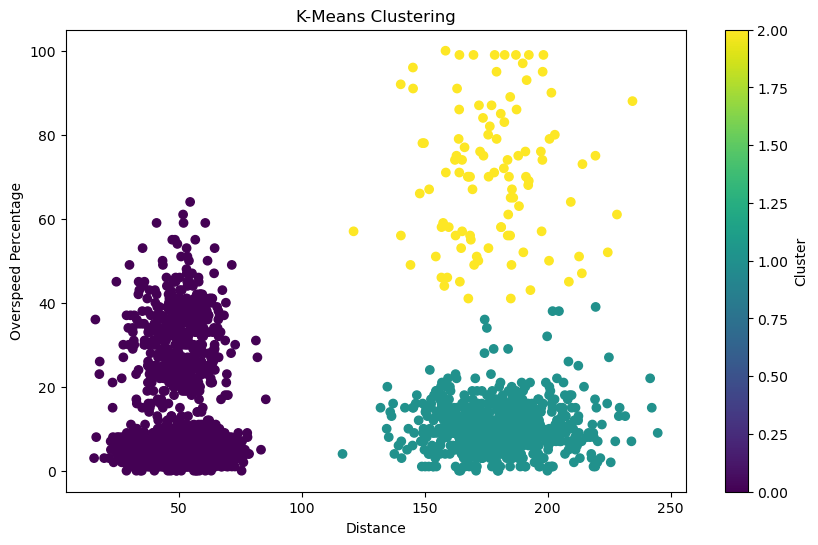

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Initialize Spark Session
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

# Load the dataset from the provided file path
df = spark.read.csv(r"C:\Users\Shriram\OneDrive\Documents\Sem 7\bdaendsemester2024\KMeans.csv", header=True, inferSchema=True)

# Rename columns to match the dataset structure
df = df.withColumnRenamed("mean_dist_day", "distance") \
       .withColumnRenamed("mean_over_speed_perc", "overspeed_percentage")

# Assemble features for K-Means clustering
assembler = VectorAssembler(inputCols=["distance", "overspeed_percentage"], outputCol="features")
df_features = assembler.transform(df).select("features")

# Initialize KMeans with 3 clusters
kmeans = KMeans(featuresCol="features", k=3)
kmeans_model = kmeans.fit(df_features)

# Make predictions and evaluate the silhouette score
kmeans_predictions = kmeans_model.transform(df_features)
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_score = evaluator.evaluate(kmeans_predictions)

# Display cluster centers
centers = kmeans_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

print(f"Silhouette Score: {silhouette_score}")

# Convert Spark DataFrame to Pandas for plotting
kmeans_pandas = kmeans_predictions.select("features", "prediction").toPandas()
kmeans_pandas['distance'] = kmeans_pandas['features'].apply(lambda x: x[0])
kmeans_pandas['overspeed_percentage'] = kmeans_pandas['features'].apply(lambda x: x[1])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(kmeans_pandas['distance'], kmeans_pandas['overspeed_percentage'], c=kmeans_pandas['prediction'], cmap='viridis', marker='o')
plt.title('K-Means Clustering')
plt.xlabel('Distance')
plt.ylabel('Overspeed Percentage')
plt.colorbar(label='Cluster')
plt.show()

# Stop the Spark Session
spark.stop()


# Earthquake- K Means.csv

+----------+-----------+---------+-------------------+-----+-----------------+--------------------+-----------------+------------------+-------------+--------+----------+----------------+---------+-----------+----------+-----------+---------+
|        id| impact.gap|magnitude|impact.significance|depth|location.distance|       location.full|location.latitude|location.longitude|location.name|time.day|time.epoch|       time.full|time.hour|time.minute|time.month|time.second|time.year|
+----------+-----------+---------+-------------------+-----+-----------------+--------------------+-----------------+------------------+-------------+--------+----------+----------------+---------+-----------+----------+-----------+---------+
|nc72666881|      122.0|     1.43|                 31|15.12|           0.1034|13km E of Livermo...|       37.6723333|          -121.619|   California|      27|1.46959E12|27-07-2016 00:19|        0|         19|         7|         43|     2016|
|us20006i0y|       30.0|    

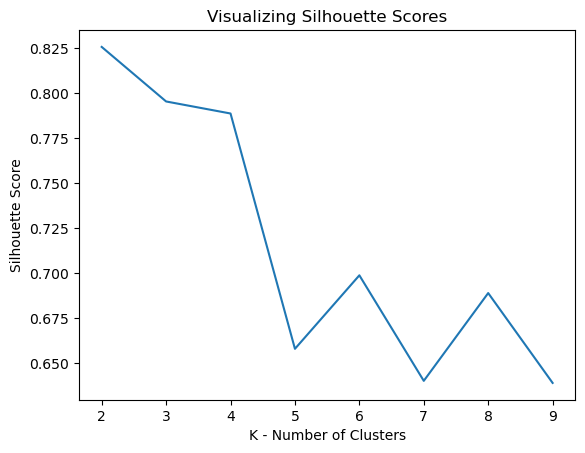

Cluster Centers: 
[3.94736431 9.58175849]
[0.96719665 0.24794489]
[3.12692702 1.18396012]
+----------+
|prediction|
+----------+
|         1|
|         2|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         2|
|         2|
|         1|
|         1|
|         1|
|         1|
|         1|
|         2|
|         1|
|         1|
|         1|
|         1|
|         2|
|         1|
|         1|
|         1|
|         2|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         2|
|         1|
|         2|
|         1|
|         1|
|         2|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|


In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Start a Spark session
spark = SparkSession.builder.appName('Clustering').getOrCreate()

# Load dataset with Spark
dataset = spark.read.csv(r"Earthquake- K Means.csv", header=True, inferSchema=True)

# Rename columns for simplicity
dataset = dataset.withColumnRenamed("impact.magnitude", "magnitude") \
                 .withColumnRenamed("location.depth", "depth")

# Display first few rows and schema
#dataset.show(10)
#dataset.printSchema()

# Assemble features for clustering
vec_assembler = VectorAssembler(inputCols=["magnitude", "depth"], outputCol='features')
final_data = vec_assembler.transform(dataset)
final_data.select('features').show(10)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)
final_data.select('scaledFeatures').show(10)

# Calculate silhouette scores for various k values
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2, 10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=i)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    score = evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =', i, 'is', score)

# Plot silhouette scores
plt.plot(range(2, 10), silhouette_score)
plt.xlabel('K - Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Visualizing Silhouette Scores')
plt.show()

# Fit final KMeans model with an optimal k (e.g., 3 based on silhouette scores)
kmeans = KMeans(featuresCol='scaledFeatures', k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

# Display cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Show cluster predictions
predictions.select('prediction').show(100)

# Stop Spark session
spark.stop()


# Earthquake- K Means.csv

Cluster Centers: 
[ 1.37762507 10.45118733]
[  4.52222222 497.09296296]
[  2.55       106.92088592]
Silhouette Score: 0.9255119097691359


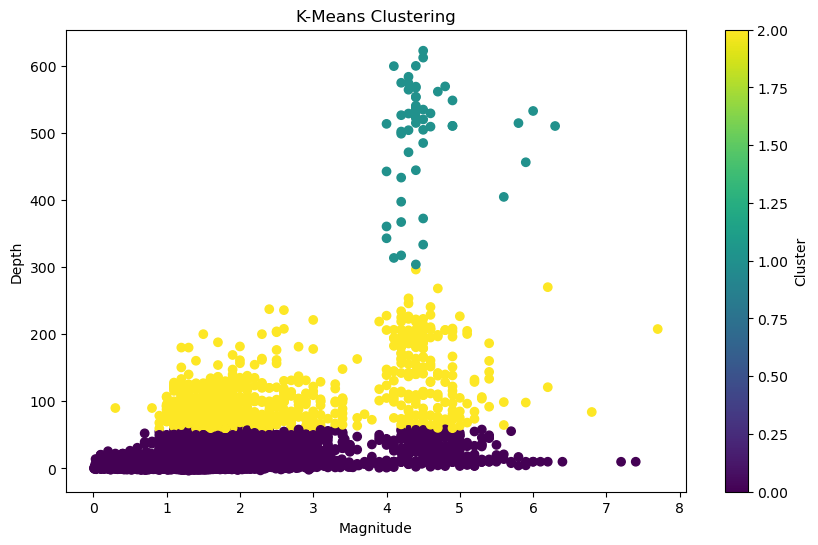

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Initialize Spark Session
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

# Load the dataset from the provided file path
df = spark.read.csv(r"Earthquake- K Means.csv", header=True, inferSchema=True)

# Rename columns for simplicity
df = df.withColumnRenamed("impact.magnitude", "magnitude") \
       .withColumnRenamed("location.depth", "depth")

# Assemble features for K-Means clustering using 'magnitude' and 'depth'
assembler = VectorAssembler(inputCols=["magnitude", "depth"], outputCol="features")
df_features = assembler.transform(df).select("features")

# Initialize KMeans with 3 clusters
kmeans = KMeans(featuresCol="features", k=3)
kmeans_model = kmeans.fit(df_features)

# Make predictions and evaluate the silhouette score
kmeans_predictions = kmeans_model.transform(df_features)
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_score = evaluator.evaluate(kmeans_predictions)

# Display cluster centers
centers = kmeans_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

print(f"Silhouette Score: {silhouette_score}")

# Convert Spark DataFrame to Pandas for plotting
kmeans_pandas = kmeans_predictions.select("features", "prediction").toPandas()
kmeans_pandas['magnitude'] = kmeans_pandas['features'].apply(lambda x: x[0])
kmeans_pandas['depth'] = kmeans_pandas['features'].apply(lambda x: x[1])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(kmeans_pandas['magnitude'], kmeans_pandas['depth'], c=kmeans_pandas['prediction'], cmap='viridis', marker='o')
plt.title('K-Means Clustering')
plt.xlabel('Magnitude')
plt.ylabel('Depth')
plt.colorbar(label='Cluster')
plt.show()

# Stop the Spark Session
spark.stop()
